In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import re

# data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Stats Libraries
from scipy import stats
!pip install researchpy # install it because it is not installed on kaggle
import researchpy as rp 
import statsmodels.api as sm 
from statsmodels.formula.api import ols  

# natural language toolkit
import nltk
from nltk.corpus import stopwords

# machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn import tree

# deep learning libraries
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


# Data Loading

Firstly, we load data from its source file, get information about the structure, then display some entries to get an overview.

In [2]:
# load the data
tweets = pd.read_csv('../input/Tweets.csv')
tweets.info()
tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The dataset contains 14640 entries, each has 15 features. All features are of object type except for two integer variables (tweet_id, retweet_count) and two floats (airline_sentiment_confidence, negativereason_confidence).

I start by dropping the irrelevant features like tweet_id, name, user_timezone, and tweet_location. These features have no impact on the sentiment analysis process.

In [3]:
tweets = tweets.drop(columns=['tweet_id', 'name', 'user_timezone', 'tweet_location'])

Then, for each feature, I show the percentage of missing values.

In [4]:
print(round(tweets.isna().mean().sort_values(),2)*100)

airline_sentiment                 0.0
airline_sentiment_confidence      0.0
airline                           0.0
retweet_count                     0.0
text                              0.0
tweet_created                     0.0
negativereason_confidence        28.0
negativereason                   37.0
tweet_coord                      93.0
airline_sentiment_gold          100.0
negativereason_gold             100.0
dtype: float64


We can see that almost all the tweets have no values for (airline_sentiment_gold, and negativereason_gold) and only 7% of the tweets have tweet_coord value. So let's drop it. 

In [5]:
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

Regarding negativereason_confidence and negative reason, it's normal to have missing values because only negative sentiments should have values.

In [6]:
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created
0,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


# Exploratory Data Analysis

I need to understand the characteristics of each feature. So I begin with the univariate analysis.

In [7]:
tweets.describe()

,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.000000,10522.000000,14640.000000
mean,0.900169,0.638298,0.082650
std,0.162830,0.330440,0.745778
min,0.335000,0.000000,0.000000
25%,0.692300,0.360600,0.000000
50%,1.000000,0.670600,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,44.000000


The descriptive statistics above shows that the average value of airline_sentiment_confidence is 0.9 and a minimum value of 0.34. the average value of negativereason_confidence is 0.64. We can see that retweet_count has high variance which is expected because its default is zero and may some tweets are retweeted that causes high variance. Let's visualize it for more details.

In [8]:
# plot histogram function
def plot_hist(x, bins, title, xlabel, ylabel):
    plt.hist(x, bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show() 

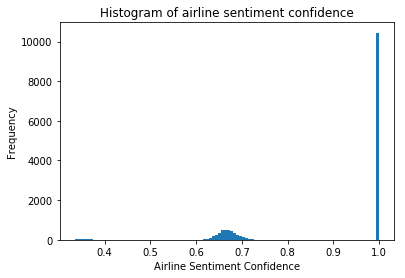

In [9]:
# plot histogram of airline sentiment confidence
plot_hist(
    tweets['airline_sentiment_confidence'], 
    bins=100, 
    xlabel ='Airline Sentiment Confidence', 
    ylabel='Frequency', 
    title='Histogram of airline sentiment confidence'
)

This histogram of airline sentiment confidence shows that we are 100% confident of the airline sentiment of more than 10000 tweets. Most of the rest lies between 62% and 72% confidence level. Regarding the distribution, it's clear that it is not a normal distribution unless we consider value "1" of the confidence is an outlier which I believe is invalid.

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


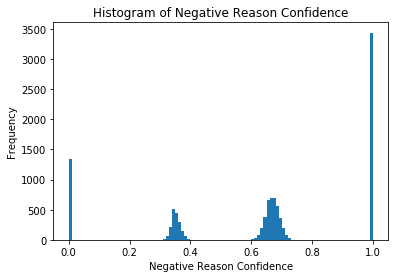

In [10]:
# plot histogram of negative reason confidence
plot_hist(
    tweets['negativereason_confidence'], 
    bins=100, 
    xlabel ='Negative Reason Confidence', 
    ylabel='Frequency', 
    title='Histogram of Negative Reason Confidence'
)

This histogram of negative reason confidence has the same distribution of the above sentiment confidence distribution. But here we can see another confidence range between 0.3 and 0.4. Also, there is almost 1400 negative reason have zero confidence. 

Now, it's time to analyze the categorical variables.

In [11]:
# define color palette
colors=sns.color_palette("hls", 10)
# plot barchart of a categorical variable 
def plot_cat(col, kind, title='', xlabel='', ylabel='', asc_order=0):
    ax = pd.Series(tweets[col]).value_counts()
    if asc_order == 1:
        ax = ax.sort_values(ascending=True)
    ax.plot(kind = kind,color=colors,figsize=(8,6),fontsize=10,rot = 0, title = title).set(xlabel=xlabel, ylabel=ylabel)
    plt.show()

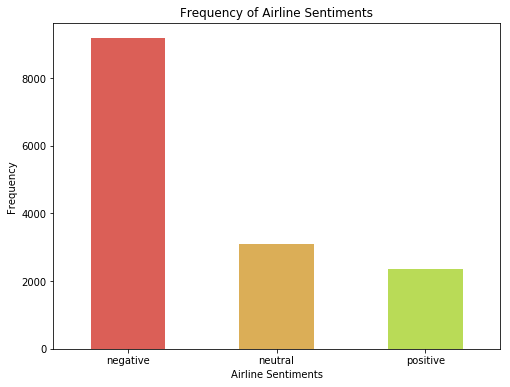

In [12]:
# plot frequency of airline sentiments
plot_cat(
    col='airline_sentiment',
    kind='bar',
    title='Frequency of Airline Sentiments',
    xlabel='Airline Sentiments',
    ylabel='Frequency'
)

As we can see, the frequency of negative tweets is much more than both neural and positive tweets. That reflects either airline has much more negatives than positive or neutral issue OR people tends to tweet for negative issues and don't care so much to talk about the positives.  

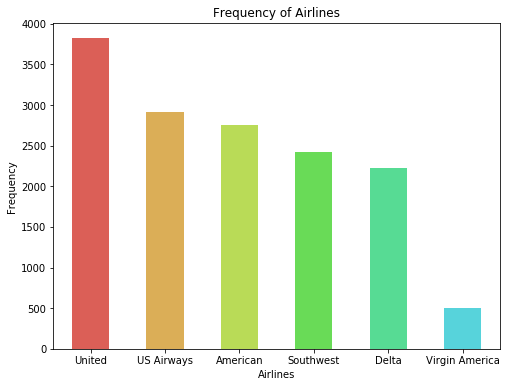

In [13]:
# plot frequency of airlines
plot_cat(
    col='airline',
    kind='bar',
    title='Frequency of Airlines',
    xlabel='Airlines',
    ylabel='Frequency'
)

United airline is the most frequent in the tweets followed by US Airway. Virgin America is the least frequent one.

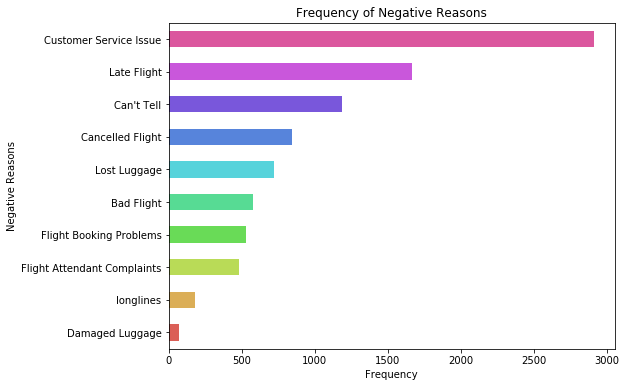

In [14]:
# plot negative reasons frequency
plot_cat(
    col='negativereason',
    kind='barh',
    title='Frequency of Negative Reasons',
    xlabel='Frequency',
    ylabel='Negative Reasons',
    asc_order=1
)

The plot reveals that the most important reason for the negative tweets is customer service followed by late flights.

Do people tend to tweet more in specific weekdays than the other day? To answer this question I need to create a new variable to represent the day of a tweet using the tweet_created variable.

In [15]:
tweets['tweet_created_dt'] = pd.to_datetime(tweets['tweet_created'])
tweets['day_of_tweet'] = tweets['tweet_created_dt'].dt.day_name()
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_created_dt,day_of_tweet
0,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,2015-02-24 19:35:52,Tuesday
1,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,2015-02-24 19:15:59,Tuesday
2,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,2015-02-24 19:15:48,Tuesday
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,2015-02-24 19:15:36,Tuesday
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,2015-02-24 19:14:45,Tuesday


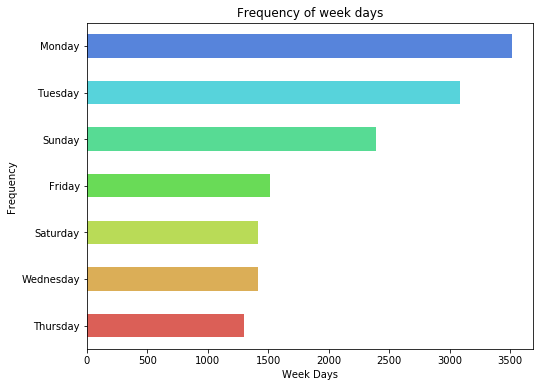

In [16]:
# plot day of tweet frequency
plot_cat(
    col='day_of_tweet',
    kind='barh',
    title='Frequency of week days',
    xlabel='Week Days',
    ylabel='Frequency',
    asc_order=1
)

We can see observed differences that need to be investigated later on. Now, It's time to explore the most interesting relationships.

**Multivariate Analysis**

I begin by exploring the relationship between airlines and sentiments.

In [17]:
# plot relationships between categorical variables
def cat_relationship_plot(y, hue, title):
    sns.catplot(y=y,hue=hue, kind="count", palette="pastel", edgecolor=".6",data=tweets);
    plt.title(title)

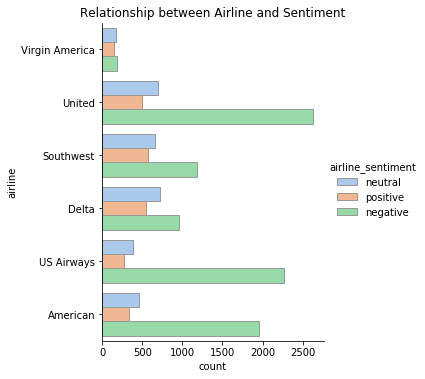

In [18]:
# plot airline vs sentiment
cat_relationship_plot(
    y='airline',
    hue='airline_sentiment',
    title='Relationship between Airline and Sentiment'
)

As we expected from a previous plot, United airline, US Airways and American are the most dominant airplanes. But the high variance of the sentiments across these airlines is a bad indicator that needs to be investigated. Regarding the other airlines like Virgin America and Delta, the sentiment variance is adequate. We can also observe that frequency of the positive sentiment across all the airline is the least one. 

I doubt that we can observe the most reasons for negative tweets of United airline, US airways and American would be customer services issues and late flights. Let make sure.

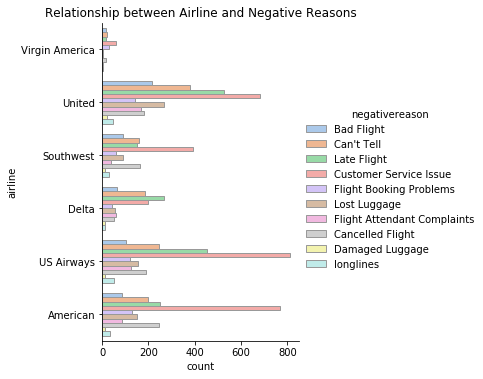

In [19]:
# plot airline vs sentiment
cat_relationship_plot(
    y='airline',
    hue='negativereason',
    title='Relationship between Airline and Negative Reasons'
)

For all airlines, the most frequent reason for negative sentiment is customer service issues except for Delta which has higher late flights frequency. 

**Sentiment across day of tweet**

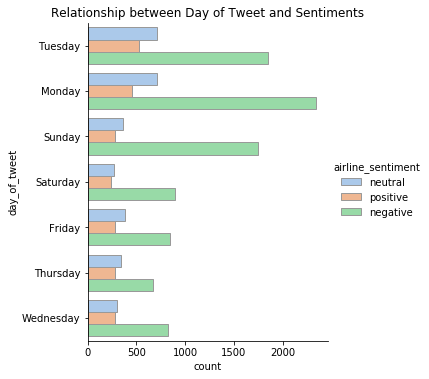

In [20]:
# plot day of tweet vs sentiment
cat_relationship_plot(
    y='day_of_tweet',
    hue='airline_sentiment',
    title='Relationship between Day of Tweet and Sentiments'
)

A previous plot shows that the frequency of tweets are very high on Sunday, Monday, and Tuesday compared to the other days. Here we can observe that these differences are not distributed among the sentiments but reflected only on the negative sentiment. These may reflect problems occurring mostly in those days or just because these days includes weekend and people always use social media on the weekend more than the other working days.  

Let's visualize the relationship between airline, sentiment, and sentiment_confidence.

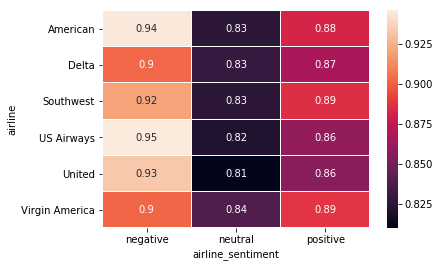

In [21]:
# plot day of airline vs sentiment vs confidence
pivot = tweets.pivot_table(
    index='airline', 
    columns='airline_sentiment', 
    values='airline_sentiment_confidence'
)
sns.heatmap(pivot, annot=True, linewidth = 0.1)

This visualization summarizes many interesting observations

* Negative sentiments have the overall highest confidence followed by positive and neutral.
* US Airway has the highest negative sentiment confidence followed by American and United.

Explore the relationship between negative reason confidence, negative reason, and airline.

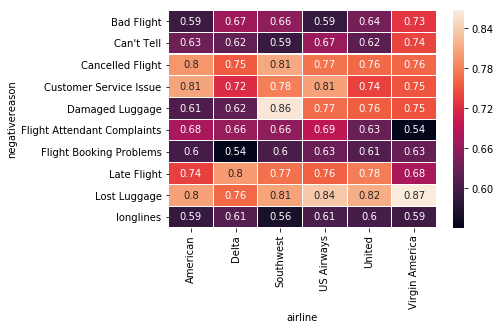

In [22]:
# plot day of airline vs negative_reason vs negativereason_confidence
pivot = tweets.pivot_table(
    index='negativereason', 
    columns='airline', 
    values='negativereason_confidence'
)
sns.heatmap(pivot,  annot=True, linewidth = 0.1)

This plot shows that canceled flights, customer service issue, and lost luggage reasons have the overall highest confidence across the airlines.

** Statistical Tests**


Is there a significant relationship between airline and airline_sentiment or they are independent variables? To answer this question, we need to state the hypothesis and choose the statistical test

let's state our null hypothesis and the alternative hypothesis.

H0: There is no statistically significant relationship between the airline and the airline_sentiment.

Ha: There is a statistically significant relationship between the airline and the airline_sentiment.

First, we need to format the data into a frequency count table (Contingency Table)

In [23]:
contingency_table = pd.crosstab(
    tweets['airline_sentiment'],
    tweets['airline'],
    margins = True
)
contingency_table

airline,American,Delta,Southwest,US Airways,United,Virgin America,All
airline_sentiment,,,,,,,
negative,1960,955,1186,2263,2633,181,9178
neutral,463,723,664,381,697,171,3099
positive,336,544,570,269,492,152,2363
All,2759,2222,2420,2913,3822,504,14640


Since we test for Independence between two categorical variables, we can use the Chi-square test..

In [24]:
f_obs = np.array([
    contingency_table.iloc[0][0:6].values,
    contingency_table.iloc[1][0:6].values,
    contingency_table.iloc[2][0:6].values
])

stats.chi2_contingency(f_obs)[0:3]

(1154.0284059890805, 1.1843123973768729e-241, 10)

The results: x-squared = ~1154, p-value = ~0 and degrees of freedom = 10.

With a p-value < 0.05, we can reject the null hypothesis. There is definitely a strong relationship between 'airline' and the 'airline_sentiment' column. We don't know what this relationship is, but we do know that these two variables are not independent of each other.

Is there a significant difference between average airline_sentiment_confidence across airline_sentiment groups(negative, positive, and neutral)?

In [25]:
tweets.groupby(['airline_sentiment'])['airline_sentiment_confidence'].mean()

airline_sentiment
negative    0.933365
neutral     0.823303
positive    0.872039
Name: airline_sentiment_confidence, dtype: float64

Let's state the hypothesis

H0: There is no statistically significant difference between mean airline_sentiment_confidence across airline_sentiment.

HA: There is a statistically significant difference between mean airline_sentiment_confidence across airline_sentiment.

In [26]:
rp.summary_cont(tweets['airline_sentiment_confidence'].groupby(tweets['airline_sentiment']))

,N,Mean,SD,SE,95% Conf.,Interval
airline_sentiment,,,,,,
negative,9178,0.933365,0.138109,0.001442,0.930540,0.936191
neutral,3099,0.823303,0.185594,0.003334,0.816768,0.829839
positive,2363,0.872039,0.179478,0.003692,0.864801,0.879277


I used One-way ANOVA to determine whether there are any statistically significant differences between the means of three or more independent groups. So it can be used here.

In [27]:
stats.f_oneway(tweets['airline_sentiment_confidence'][tweets['airline_sentiment'] == 'negative'], 
             tweets['airline_sentiment_confidence'][tweets['airline_sentiment'] == 'neutral'],
             tweets['airline_sentiment_confidence'][tweets['airline_sentiment'] == 'positive'])

F_onewayResult(statistic=619.568753401287, pvalue=5.126220869823719e-259)

p-value < 0.05. This tells us that there is a significant difference in the three sample means. But this doesn't provide information about which group is different. So, I use the regression linear model to get more details. 

In [28]:
results = ols('airline_sentiment_confidence ~ C(airline_sentiment)', data=tweets).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     airline_sentiment_confidence   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.078
Method:                           Least Squares   F-statistic:                     619.6
Date:                          Wed, 29 May 2019   Prob (F-statistic):          5.13e-259
Time:                                  06:19:28   Log-Likelihood:                 6394.4
No. Observations:                         14640   AIC:                        -1.278e+04
Df Residuals:                             14637   BIC:                        -1.276e+04
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9334      0.002    571.884      0.000       0.930       0.937
C(airline_sentiment)[T.neutral]     -0.1101      0.003    -33.881      0.000      -0.116      -0.104
C(airline_sentiment)[T.positive]    -0.0613      0.004    -17.003      0.000      -0.068      -0.054
==============================================================================
Omnibus:                     2179.167   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3280.571
Skew:                          -1.137   Prob(JB):                         0.00
Kurtosis:                       3.457   Cond. No.                         3.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let’s interpret the table. Overall the model is significant, p = 5.13e-259. This tells us that there is a significant difference in the group means. By looking at coefficients, we can see the difference in mean between the control group(negative sentiment) and the respective group listed. The intercept is the mean of the negative sentiment group, neutral group’s coefficient = -0.1, and positive group’s coefficient = -0.06. Looking at the P>|t| in the table, we can see the difference between the negative group and both neutral and positive = 0 which is significant.

In the following sections, we will focus on using tweet text to predict the sentiment using machine learning and deep learning techniques. 

In [29]:
features = tweets.iloc[:, 6].values  
labels = tweets.iloc[:, 0].values 
print(features[0], labels[0])

@VirginAmerica What @dhepburn said. neutral


# Machine Learning

**Text cleaning**

There is less to learn from neutral texts comparing to the ones with clear positive or negative sentiment. So, I started with ignoring the entries of neutral sentiments. Then I removed the special characters and all single characters, substituted multiple spaces with single space, and finally convert it to lowercase.

In [30]:
non_neutral_features = tweets[tweets.airline_sentiment != 'neutral']
features = non_neutral_features['text']
# Remove all the special characters
features = features.apply((lambda x: re.sub(r'\W', ' ',x)))
# remove all single characters
features = features.apply((lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)))
# Substituting multiple spaces with single space
features = features.apply((lambda x: re.sub(r'\s+', ' ', x, flags=re.I)))
# Converting to Lowercase
features = features.apply(lambda x: x.lower())

labels = non_neutral_features['airline_sentiment']

**Converting text to numbers**

To make ML algorithms work with text, we have to convert text to numbers. To do so, I create a Bag of Words along with TF-IDF.

In [31]:
vectorizer = CountVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))  
vec_features = vectorizer.fit_transform(features).toarray() 

**Splitting data into training and testing sets**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(vec_features, labels, test_size=0.2, random_state=0)  

I assigned 80% for training and the remaining 20% for testing.

There are many different algorithms we can choose from when doing sentiment analysis with machine learning. I'll try different algorithms like SVM, RandomForestClassifier, and DecisionTreeClassifier.

**SVM**

In [33]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="macro"))

Accuracy: 0.913382416630576
Precision: 0.8721846696735635
Recall: 0.8553411312808765


**Random Forest Classifier**

In [34]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="macro"))

Accuracy: 0.902555218709398
Precision: 0.851550373903315
Recall: 0.8453761873358555


**Decision Tree Classifier**

In [35]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="macro"))

Accuracy: 0.8618449545257687
Precision: 0.7849092462096947
Recall: 0.8087316187104463


As we can see, SVM has the best evaluation metrics. So, I'll tune its hyperparameters to improve the performance.

In [36]:
for c in [0.01, 0.1, 1, 10]:
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('using C:', c)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred, average="macro"))
    print("Recall:",metrics.recall_score(y_test, y_pred, average="macro"))
    print("---------------------------------------------")

using C: 0.01
Accuracy: 0.8570809874404504
Precision: 0.8154328796975436
Recall: 0.6996205153124385
---------------------------------------------
using C: 0.1
Accuracy: 0.9125162407968818
Precision: 0.8929101426875434
Recall: 0.8247035275878426
---------------------------------------------
using C: 1
Accuracy: 0.913382416630576
Precision: 0.8721846696735635
Recall: 0.8553411312808765
---------------------------------------------
using C: 10
Accuracy: 0.895625812039844
Precision: 0.8365811591271715
Recall: 0.8465695972603057
---------------------------------------------


The second and third versions of the model (C=0.1, C=1) achieve the best values of the evaluation metrics. Both of them has almost the same Accuracy, one has higher Precision and the other has higher Recall.

<table>
    <tr>
        <td>Algorithm</td>
        <td>Accuracy</td>
        <td>Precision</td>
        <td>Recall</td>
    </tr>
    <tr>
        <td>SVM</td>
        <td>91%</td>
        <td>89%</td>
        <td>82%</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>90%</td>
        <td>85%</td>
        <td>85%</td>
    </tr>
    <tr>
        <td>DecisionTreeClassifier</td>
        <td>86%</td>
        <td>78%</td>
        <td>80%</td>
    </tr>
</table>


## Deep Learning

LSTM layes are widely used for language processing, this is why I used this kind of layer for my classifier.

**Generate embeddings**

In [37]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(features.values)
X = tokenizer.texts_to_sequences(features.values)
X = pad_sequences(X)

**LSTM Network Architecture**

In [38]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 128)           256000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


**Splitting Data into train and test sets**

In [39]:
Y = pd.get_dummies(labels).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

**Splitting training data into training and validation sets**

In [40]:
X_val = X_train[:500]
Y_val = Y_train[:500]
X_train = X_train[500:]
Y_train = Y_train[500:]

**Network Training and Evaluation**

In [41]:
batch_size = 512
epochs = 30

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
saveBestModel = keras.callbacks.ModelCheckpoint('../best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(X_train, 
                    Y_train, 
                    epochs = epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val),
                    callbacks=[earlyStopping, saveBestModel])

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Instructions for updating:
Use tf.cast instead.
Train on 7232 samples, validate on 500 samples
Epoch 1/30
7232/7232 [==============================] - 4s 614us/step - loss: 0.5529 - acc: 0.7782 - val_loss: 0.4046 - val_acc: 0.8140
Epoch 2/30
7232/7232 [==============================] - 1s 123us/step - loss: 0.3832 - acc: 0.8305 - val_loss: 0.3294 - val_acc: 0.8520
Epoch 3/30
7232/7232 [==============================] - 1s 109us/step - loss: 0.2954 - acc: 0.8679 - val_loss: 0.2507 - val_acc: 0.8960
Epoch 4/30
7232/7232 [==============================] - 1s 111us/step - loss: 0.2089 - acc: 0.9222 - val_loss: 0.2039 - val_acc: 0.9280
Epoch 5/30
7232/7232 [==============================] - 1s 111us/step - loss: 0.1657 - acc: 0.9376 - val_loss: 0.1968 - val_acc: 0.9320
Epoch 6/30
7232/7232 [==============================] - 1s 116us/step - loss: 0.1440 - acc: 0.9433 - val_loss: 0.1930 - val_acc: 0.9260
Epoch 7/30
7232/7232 [==============================] - 1s 108us/step - loss: 0.1194 - ac

I trained the network for 30 epochs on maximum with the early stopping feature.

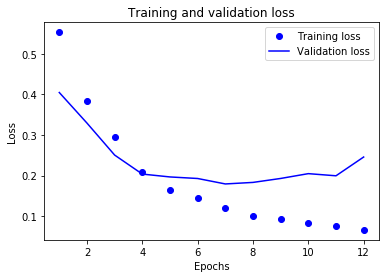

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both training and validation losses keep decreasing until epoch 6 after which the training loss continue decreasing while the validation loss starts to increase. That is an indicator of overfitting.

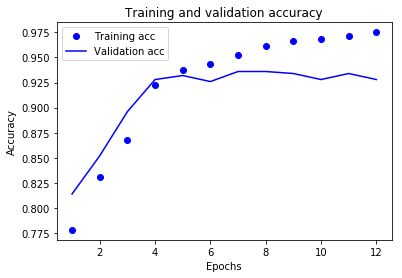

In [43]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training accuracy keeps increasing (which is normal during the training process). After epoch 6, the validation accuracy startS decreasing. That copes with the previous plot which reflects overfitting.

# Conclusion

So far, we have investigated the dataset, explored multiple interesting relationships such as those between airline, sentiment, and sentiment confidence, besides those between negative reasons and airlines.
Using statistical tests, we can confidently say that airlines and sentiment are independent features. Also, there's no significant difference between mean airline_sentiment_confidence across airline_sentiment.
We have trained multiple ML sentiment classifiers. SVM was the best one with 91% accuracy and 89% precision. A simple LSTM network architecture achieves 91.6% accuracy.

**Further Work**

* Consider the neutral sentiment entries in model training and evaluation.
* Build more complex LSTM network architecture which I believe can achieve better results.
